In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xarray.ufuncs import cos, deg2rad, log
import climlab
from metpy.plots import SkewT

In [2]:
# This will try to read the data over the internet.
temperature_filename = 'air.mon.1981-2010.ltm.nc'
#  to read over internet
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/pressure/"
#  Open handle to data
ncep_air = xr.open_dataset(ncep_url + temperature_filename, decode_times=False)

In [3]:
#  Take global, annual average and convert to Kelvin
weight = cos(deg2rad(ncep_air.lat)) / cos(deg2rad(ncep_air.lat)).mean(dim='lat')
Tzon = ncep_air.air.mean(dim=('time','lon'))
Tglobal = (Tzon * weight).mean(dim=('lat')) 

In [4]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

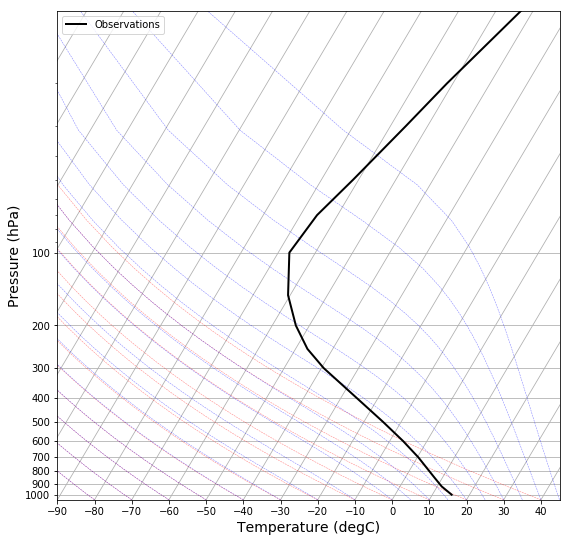

In [5]:
skew = make_skewT()

In [6]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/BrianRose/CESM_runs/"
endstr = "/entry.das"
atm_control = xr.open_dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr, decode_times=False)

In [7]:
Qglobal = ((atm_control.Q * atm_control.gw)/atm_control.gw.mean(dim='lat')).mean(dim=('lat','lon','time'))

In [8]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)

In [9]:
rad = climlab.radiation.RRTMG(name='all gases',
                              state=state, 
                              specific_humidity=Qglobal.values,
                              timestep = climlab.constants.seconds_per_day,
                              albedo = 0.25,  # tuned to give reasonable ASR for reference cloud-free model
                             )

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc


In [10]:
rad_noO3 = climlab.process_like(rad)
rad_noO3.absorber_vmr['O3'] *= 0.
rad_noO3.name = 'no O3'

rad_noH2O = climlab.process_like(rad)
rad_noH2O.specific_humidity *= 0.
rad_noH2O.name = 'no H2O'

rad_noO3_noH2O = climlab.process_like(rad_noO3)
rad_noO3_noH2O.specific_humidity *= 0.
rad_noO3_noH2O.name = 'no O3, no H2O'

In [11]:
rad_models = [rad, rad_noO3, rad_noH2O, rad_noO3_noH2O]

In [12]:
for model in rad_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

In [13]:
rc_models = []
for r in rad_models:
    newrad = climlab.process_like(r)
    conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment',
                                               state=newrad.state,
                                               adj_lapse_rate=6.5,
                                               timestep=newrad.timestep,)
    rc = newrad + conv
    rc.name = newrad.name
    rc_models.append(rc)

In [14]:
for model in rc_models:
    for n in range(100):
        model.step_forward()
    while (np.abs(model.ASR-model.OLR)>0.01):
        model.step_forward()

In [15]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

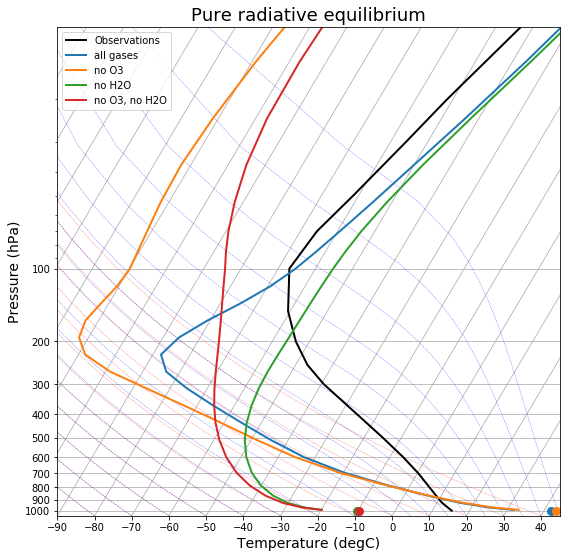

In [16]:
skew = make_skewT()
for model in rad_models:
    add_profile(skew, model)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

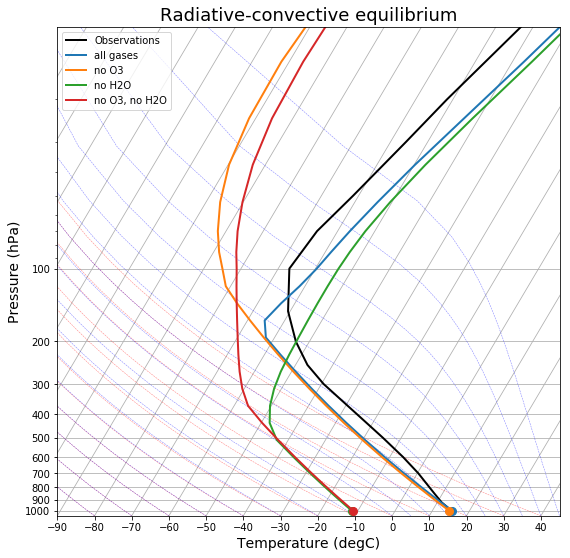

In [17]:
skew = make_skewT()
for model in rc_models:
    add_profile(skew, model)
skew.ax.set_title('Radiative-convective equilibrium', fontsize=18);

In [18]:
#  Make a model on same vertical domain as the GCM
state = climlab.column_state(lev=Qglobal.lev, water_depth=2.5)
#  Initialize a nearly dry column (small background stratospheric humidity)
state['q'] = np.ones_like(state.Tatm) * 5.E-6
#  ASYNCHRONOUS COUPLING -- the radiation uses a much longer timestep
short_timestep = climlab.constants.seconds_per_hour
#  Radiation coupled to water vapor
rad = climlab.radiation.RRTMG(name='Radiation',
                    state=state,
                    specific_humidity=state.q,
                    albedo=0.2,
                    timestep=24*short_timestep)
#  Convection scheme -- water vapor is a state variable
conv = climlab.convection.EmanuelConvection(name='Convection',
                              state=state,
                              timestep=short_timestep,
                              ALPHA=0.1,
                              IPBL=1,)
#  Surface heat flux processes
shf = climlab.surface.SensibleHeatFlux(name='SHF',
                              state=state, Cd=0.5E-3, U=10.,
                              timestep=short_timestep)
lhf = climlab.surface.LatentHeatFlux(name='LHF',
                              state=state, Cd=2*0.5E-3, U=10.,
                              timestep=short_timestep)
#  Couple all the submodels together
turb = climlab.couple([shf,lhf], name='Turbulent')
model = climlab.couple([rad, conv, turb], name='RadiativeConvectiveModel')
print(model)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (1,) 
  Tatm: (26,) 
  q: (26,) 
The subprocess tree: 
RadiativeConvectiveModel: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Convection: <class 'climlab.convection.emanuel_convection.EmanuelConvection'>
   Turbulent: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
      SHF: <class 'climlab.surface.turbulent.SensibleHeatFlux'>
      LHF: <class 'climlab.surface.turbulent.LatentHeatFlux'>



In [19]:
model.compute_diagnostics()
while np.abs(model.ASR-model.OLR) > 0.01:
    model.step_forward()

In [20]:
for n in range(1000):
    model.step_forward()

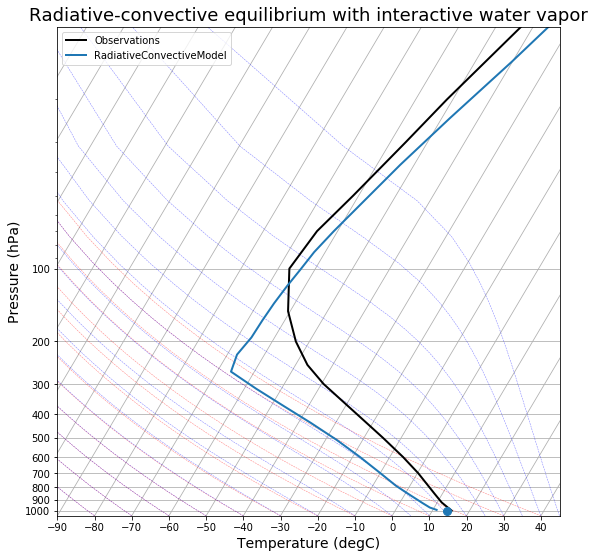

In [21]:
skew = make_skewT()
add_profile(skew, model)
skew.ax.set_title('Radiative-convective equilibrium with interactive water vapor', fontsize=18);

In [22]:
model.ASR

Field([ 261.91467628])

## A 2D Radiative-Convective model

In [23]:
Qlat = atm_control.Q.mean(dim=('time','lon'))

In [24]:
state = climlab.column_state(lat=Qlat.lat, lev=Qlat.lev, water_depth=2.5)

In [25]:
climlab.to_xarray(state)

<xarray.Dataset>
Dimensions:       (depth: 1, depth_bounds: 2, lat: 96, lat_bounds: 97, lev: 26, lev_bounds: 27)
Coordinates:
  * lat           (lat) float64 -90.0 -88.11 -86.21 -84.32 -82.42 -80.53 ...
  * depth         (depth) float64 1.25
  * lat_bounds    (lat_bounds) float64 -90.0 -89.05 -87.16 -85.26 -83.37 ...
  * depth_bounds  (depth_bounds) float64 0.0 2.5
  * lev           (lev) float64 3.545 7.389 13.97 23.94 37.23 53.11 70.06 ...
  * lev_bounds    (lev_bounds) float64 0.0 5.467 10.68 18.96 30.59 45.17 ...
Data variables:
    Ts            (lat, depth) float64 288.0 288.0 288.0 288.0 288.0 288.0 ...
    Tatm          (lat, lev) float64 200.0 203.1 206.2 209.4 212.5 215.6 ...

In [26]:
#  Hard convective adjustment
conv = climlab.convection.ConvectiveAdjustment(name='Convective Adjustment', state=state, adj_lapse_rate=6.5)
#  Daily insolation as a function of latitude and time of year
sun = climlab.radiation.DailyInsolation(name='Daily Insolation', domains=state.Ts.domain)
#  Couple the radiation to insolation and water vapor processes
rad = climlab.radiation.RRTMG(name='Radiation',
                              state=state, 
                              specific_humidity=Qlat.values.transpose(), 
                              albedo=0.125,
                              insolation=sun.insolation,
                              coszen=sun.coszen)
model = climlab.couple([rad,sun,conv], name='Seasonal RC Model')
print(model)

Getting ozone data from /Users/br546577/anaconda3/lib/python3.6/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
climlab Process of type <class 'climlab.process.time_dependent_process.TimeDependentProcess'>. 
State variables and domain shapes: 
  Ts: (96, 1) 
  Tatm: (96, 26) 
The subprocess tree: 
Seasonal RC Model: <class 'climlab.process.time_dependent_process.TimeDependentProcess'>
   Radiation: <class 'climlab.radiation.rrtm.rrtmg.RRTMG'>
      SW: <class 'climlab.radiation.rrtm.rrtmg_sw.RRTMG_SW'>
      LW: <class 'climlab.radiation.rrtm.rrtmg_lw.RRTMG_LW'>
   Daily Insolation: <class 'climlab.radiation.insolation.DailyInsolation'>
   Convective Adjustment: <class 'climlab.convection.convadj.ConvectiveAdjustment'>



In [27]:
model.compute_diagnostics()

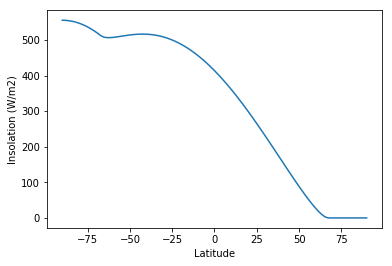

In [28]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.insolation)
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)');

In [29]:
model.integrate_years(10.)

Integrating for 3652 steps, 3652.4220000000005 days, or 10.0 years.
Total elapsed time is 9.99884460229 years.


In [30]:
model.integrate_years(1.)

Integrating for 365 steps, 365.2422 days, or 1.0 years.
Total elapsed time is 10.9981814807 years.


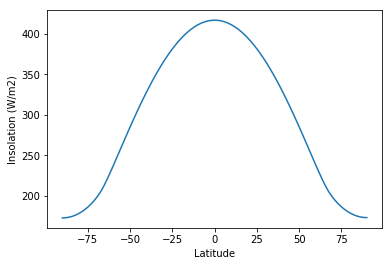

In [31]:
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['insolation'])
ax.set_xlabel('Latitude')
ax.set_ylabel('Insolation (W/m2)')

In [32]:
#  daily surface temperature from  NCEP reanalysis
ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_temp = xr.open_dataset( ncep_url + "surface_gauss/skt.sfc.day.1981-2010.ltm.nc", decode_times=False)
ncep_temp_zon = ncep_temp.skt.mean(dim='lon')

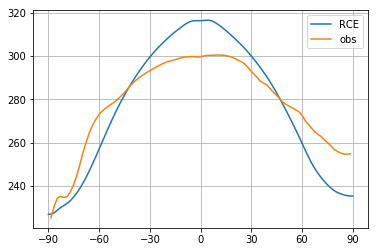

In [33]:
# Plot annual mean surface temperature in the model,
#   compare to observed annual mean surface temperatures
fig, ax = plt.subplots()
ax.plot(model.lat, model.timeave['Ts'], label='RCE')
ax.plot(ncep_temp_zon.lat, ncep_temp_zon.mean(dim='time'), label='obs')
ax.set_xticks(range(-90,100,30))
ax.grid(); ax.legend();


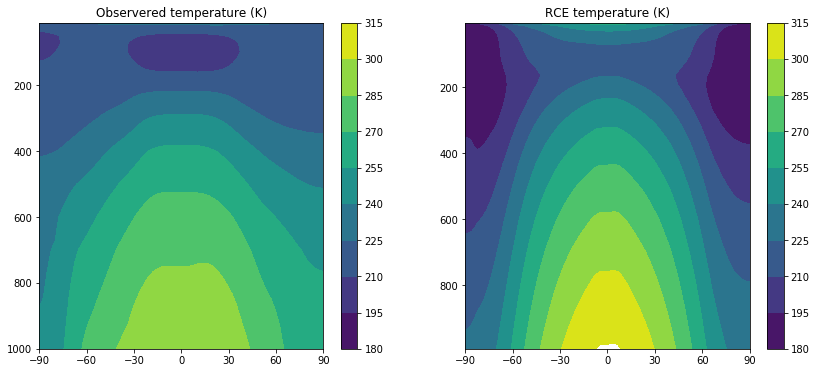

In [34]:
#  Compare temperature profiles in RCE and observations
contours = np.arange(180., 330., 15.)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
cax1 = ax1.contourf(ncep_air.lat, ncep_air.level, Tzon+273.15, levels=contours)
fig.colorbar(cax1)
ax1.set_title('Observered temperature (K)')

ax2 = fig.add_subplot(1,2,2)
field = model.timeave['Tatm'].transpose()
cax2 = ax2.contourf(model.lat, model.lev, field, levels=contours)
fig.colorbar(cax2)
ax2.set_title('RCE temperature (K)')

for ax in [ax1, ax2]:
    ax.invert_yaxis()
    ax.set_xlim(-90,90)
    ax.set_xticks([-90, -60, -30, 0, 30, 60, 90])

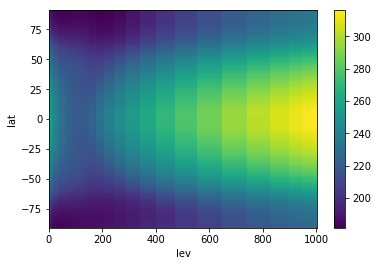

In [35]:
model.timeave['Tatm'].to_xarray().plot()